# CUSTOMER SEGMENTATION ANALYSIS

## Import Libraries

In [25]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer,intercluster_distance
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, estimate_bandwidth
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import metrics
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In the prevous notebook after data exploration, i created a function that facilitates importing and cleaning the data. ill refer back to the function reproduce the clean Data and carry on with data analysis.

In [3]:
def wrangle(filepath):
    # read csv into DataFrame
    df = pd.read_csv(filepath,sep='\t')
    
    # dropping null values 
    df = df.dropna()
    
    # Feature Engineering
    # Calculate the present age of customer
    df["Age"] = 2021 - df["Year_Birth"]

    # Calculate the total spending on various items
    df["Spent"] = df[["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]].sum(axis=1)

    # extracting living situation by marital status
    df["Living_With"] = df["Marital_Status"].replace({"Married": "Partner", "Together": "Partner", "Absurd": "Alone", "Widow": "Alone", "YOLO": "Alone", "Divorced": "Alone", "Single": "Alone"})

    # Feature indicating total children living in the household
    df["Children"] = df["Kidhome"] + df["Teenhome"]

    # total members in the household
    df["Family_Size"] = df["Living_With"].replace({"Alone": 1, "Partner": 2}) + df["Children"]
    
    # website activity
    website_cols = ['NumWebPurchases', 'NumWebVisitsMonth']
    df['Website_Activity'] = df[website_cols].sum(axis=1)
    
    # Income ratio
    df['Income_Ratio'] = df['Spent'] / df['Income']
    
    # total number of campaigns responded to by each customer
    response_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
    df['Campaign_Response'] = df[response_cols].sum(axis=1)

    # most frequent purchasing channel
    purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
    df['Purchasing_Channel'] = df[purchase_cols].idxmax(axis=1).str.replace('Num', '')
    
    # Feature pertaining to parenthood
    df["Is_Parent"] = (df["Children"] > 0).astype(int)

    # Stratifying education levels into three groups
    df["Education"] = df["Education"].replace({"Basic": "Undergraduate", "2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"})

    # Dropping some redundant features
    to_drop = ['Year_Birth', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
        'Kidhome', 'Teenhome', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Dt_Customer',
        'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'Response', 'Marital_Status',
        'Z_CostContact', 'Z_Revenue', 'NumWebVisitsMonth', 'NumDealsPurchases'
    ]
    df = df.drop(to_drop, axis=1)
    
    # Calculate the IQR for 'Age' and 'Income'
    Q1_age = df['Age'].quantile(0.25)
    Q3_age = df['Age'].quantile(0.75)
    IQR_age = Q3_age - Q1_age

    Q1_income = df['Income'].quantile(0.25)
    Q3_income = df['Income'].quantile(0.75)
    IQR_income = Q3_income - Q1_income

    # Define the lower and upper bounds for outliers
    lower_bound_age = Q1_age - 1.5 * IQR_age
    upper_bound_age = Q3_age + 1.5 * IQR_age

    lower_bound_income = Q1_income - 1.5 * IQR_income
    upper_bound_income = Q3_income + 1.5 * IQR_income

    # Identify outliers
    outliers_age = df[(df['Age'] < lower_bound_age) | (df['Age'] > upper_bound_age)]
    outliers_income = df[(df['Income'] < lower_bound_income) | (df['Income'] > upper_bound_income)]

    # Count the number of outliers
    num_outliers_age = len(outliers_age)
    num_outliers_income = len(outliers_income)
    
    # Remove outliers from 'Age'
    df = df[(df['Age'] >= lower_bound_age) & (df['Age'] <= upper_bound_age)]

    # Remove outliers from 'Income'
    df = df[(df['Income'] >= lower_bound_income) & (df['Income'] <= upper_bound_income)]

    # Reset the index after removing rows
    df.reset_index(drop=True, inplace=True)

    
    return df
    

In [4]:
df = wrangle("marketing_campaign.csv")
df.head()

,ID,Education,Income,Recency,Complain,Age,Spent,Living_With,Children,Family_Size,Website_Activity,Income_Ratio,Campaign_Response,Purchasing_Channel,Is_Parent
0,5524,Graduate,58138.0,58,0,64,1617,Alone,0,1,15,0.027813,1,CatalogPurchases,0
1,2174,Graduate,46344.0,38,0,67,27,Alone,2,3,6,0.000583,0,StorePurchases,1
2,4141,Graduate,71613.0,26,0,56,776,Partner,0,2,12,0.010836,0,StorePurchases,0
3,6182,Graduate,26646.0,26,0,37,53,Partner,1,3,8,0.001989,0,StorePurchases,1
4,5324,Postgraduate,58293.0,94,0,40,422,Partner,1,3,10,0.007239,0,StorePurchases,1


## Preparing Data and Adjusting Scales (Scaling)

I'll identify the categorical Features 

In [5]:
#Get list of categorical Features
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical variables in the dataset:", categorical_cols)


Categorical variables in the dataset: ['Education', 'Living_With', 'Purchasing_Channel']


In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Apply label encoding to categorical columns
le = LabelEncoder()
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].apply(lambda col: le.fit_transform(col))

# Apply standard scaling to numerical columns
scaler = StandardScaler()
num_cols = df.select_dtypes(exclude='object').columns
df[num_cols] = scaler.fit_transform(df[num_cols])

# Read the df
df.head()


,ID,Education,Income,Recency,Complain,Age,Spent,Living_With,Children,Family_Size,Website_Activity,Income_Ratio,Campaign_Response,Purchasing_Channel,Is_Parent
0,-0.018923,-0.892338,0.314651,0.310830,-0.095673,1.017189,1.679323,-1.347625,-1.266589,-1.759012,1.573210,1.061409,0.614920,-2.189411,-1.58466
1,-1.050705,-0.892338,-0.254877,-0.380600,-0.095673,1.273530,-0.963897,-1.347625,1.403420,0.448513,-0.972274,-0.555254,-0.503808,-0.362140,0.63105
2,-0.444880,-0.892338,0.965354,-0.795458,-0.095673,0.333612,0.281242,0.742046,-1.266589,-0.655250,0.724716,0.053487,-0.503808,-0.362140,-1.58466
3,0.183737,-0.892338,-1.206087,-0.795458,-0.095673,-1.289883,-0.920675,0.742046,0.068415,0.448513,-0.406610,-0.471754,-0.503808,-0.362140,0.63105
4,-0.080522,0.571654,0.322136,1.555404,-0.095673,-1.033542,-0.307248,0.742046,0.068415,0.448513,0.159053,-0.160049,-0.503808,-0.362140,0.63105


## Dimensionality Reduction Using Principal Component Analysis

PCA (Principal Component Analysis) is a technique that simplifies complex datasets. It identifies and keeps the most informative aspects of the data while discarding less important ones. This simplification process reduces the dataset's dimensions, making it more manageable and efficient for analysis. It's like distilling essential information from a large dataset, allowing us to focus on the most critical factors and patterns, simplifying our understanding and decision-making.

For this project i'll set n = 3

In [7]:
# Create a copy of the scaled dataset
Z = df.copy()

# Apply PCA for dimensionality reduction, retaining 3 components
pca = PCA(n_components=3)

# Fit the PCA model and transform the data
Z_pca = pca.fit_transform(Z)

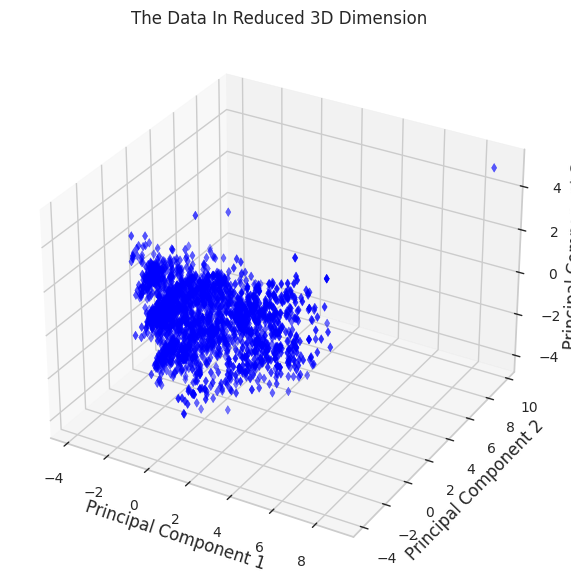

In [77]:
#Z_pca has three principal components
Z_pca_3d = Z_pca[:, :3]

# CreatING a 3D scatter plot with a different color
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

# specifying a color
ax.scatter(Z_pca_3d[:, 0], Z_pca_3d[:, 1], Z_pca_3d[:, 2], c='blue', marker='d')

# Specify  font 
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

ax.set_title('The Data In Reduced 3D Dimension')

plt.show()


# Clustering 

To check the optimal number of clusters, I will  the following evaluation techniques namely;

* Elbow Curve method
* Silhouette score Curve method
* Calinski-Harabasz index curve

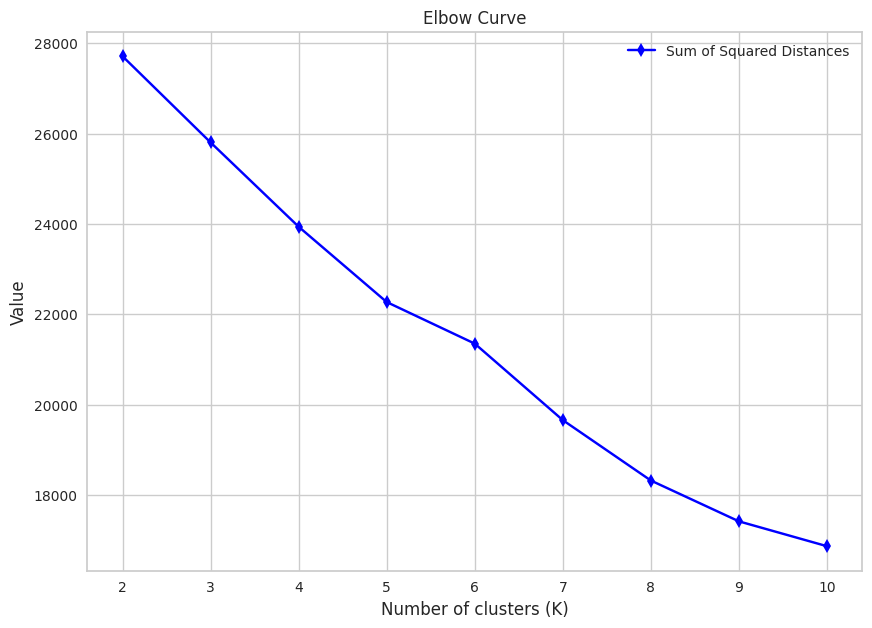

The optimal number of clusters (Elbow method) is: 6


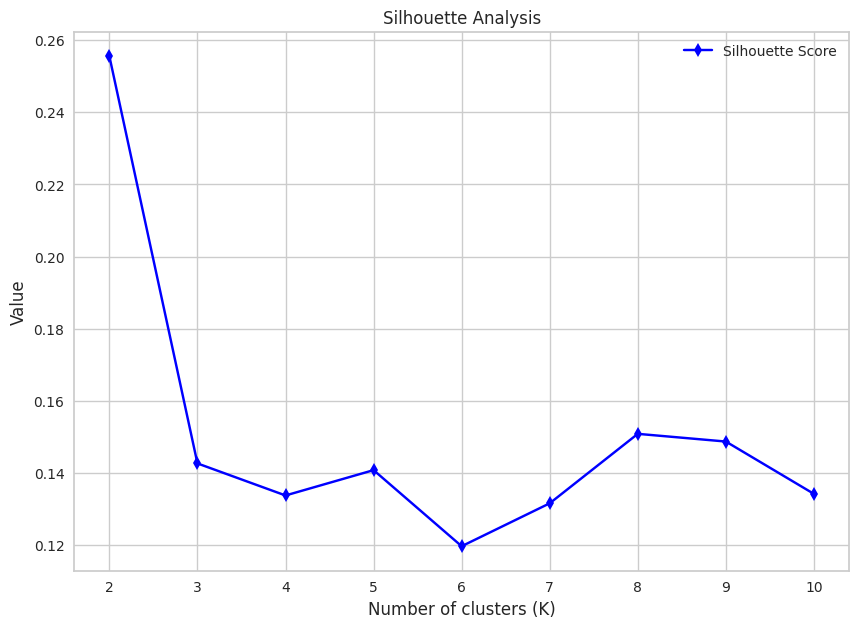

The optimal number of clusters (Silhouette method) is: 2


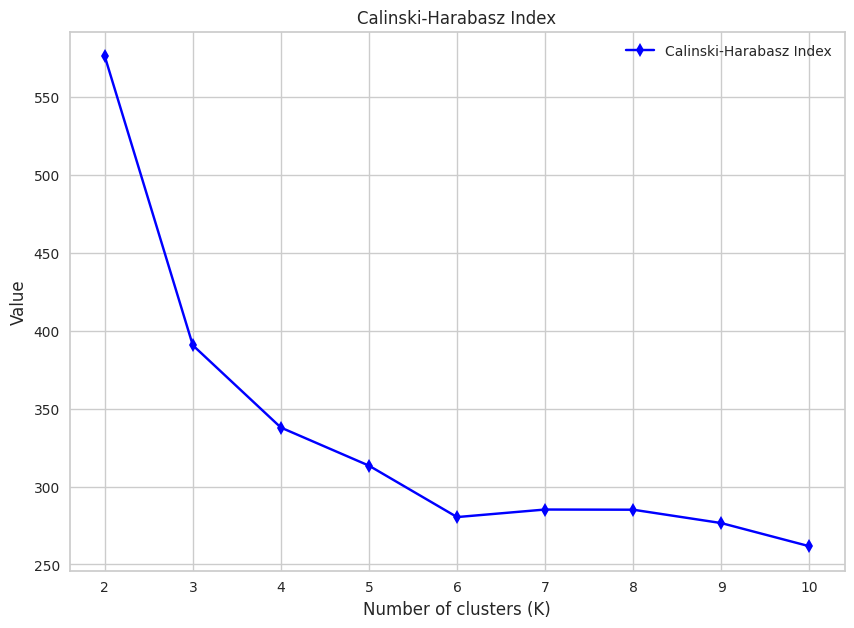

The optimal number of clusters (Calinski-Harabasz method) is: 2


In [76]:
# Define the range of clusters
min_clusters = 2
max_clusters = 10
cluster_range = range(min_clusters, max_clusters + 1)

# Initialize lists to store metrics
distortions = []
silhouette_scores = []
ch_scores = []

# Fit K-means and compute the metrics
for k in cluster_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df)
    distortions.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df, kmeans.labels_))
    ch_scores.append(calinski_harabasz_score(df, kmeans.labels_))

# Plot the elbow curve
plt.figure(figsize=[10, 7])
plt.plot(cluster_range, distortions, marker='d', label='Sum of Squared Distances', color='blue')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Value')
plt.title('Elbow Curve')
plt.legend()
plt.show()

# Calculate the rate of change and find the optimal K for the elbow method
rate_of_change = np.diff(distortions)
rate_of_change_ratio = rate_of_change[1:] / rate_of_change[:-1]
optimal_k_elbow = np.argmax(rate_of_change_ratio) + min_clusters + 1
print(f"The optimal number of clusters (Elbow method) is: {optimal_k_elbow}")

# Plot the silhouette scores
plt.figure(figsize=[10, 7])
plt.plot(cluster_range, silhouette_scores, marker='d', label='Silhouette Score', color='blue')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Value')
plt.title('Silhouette Analysis')
plt.legend()
plt.show()

# Specify  font 
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

# Find the optimal K for the silhouette method
optimal_k_silhouette = cluster_range[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters (Silhouette method) is: {optimal_k_silhouette}")

# Plot the Calinski-Harabasz scores
plt.figure(figsize=[10, 7])
plt.plot(cluster_range, ch_scores, marker='d', label='Calinski-Harabasz Index', color='blue')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Value')
plt.title('Calinski-Harabasz Index')
plt.legend()
plt.show()

# Find the optimal K for the Calinski-Harabasz method
optimal_k_ch = cluster_range[np.argmax(ch_scores)]
print(f"The optimal number of clusters (Calinski-Harabasz method) is: {optimal_k_ch}")


In this scenario, our primary focus will be on the *Silhouette* method and the *Calinski-Harabasz* method as they offer valuable insights into cluster quality and separation.
The *Silhouette* method recommends 2 clusters, implying that data points within each cluster are well-separated from those in other clusters, potentially indicating a clear distinction between two prominent customer segments.
Similarly, the *Calinski-Harabasz* method also suggests 2 clusters, signifying substantial inter-cluster variance compared to intra-cluster variance. This implies well-defined and distinct clusters.
After conducting PCA for dimensionality reduction and determining the optimal cluster count, we will proceed to cluster the data and visualize it using the Agglomerative Clustering algorithm.

 ## 1. Agglomerative Clustering

After reducing the attributes to two dimensions, my next step involves segmenting the data through Agglomerative clustering. Agglomerative clustering is a hierarchical method that merges examples iteratively until the desired number of clusters is reached. Based on our previous analysis, which indicated that 2 is the optimal number of clusters, we will configure Agglomerative Clustering accordingly.

Cluster Counts:
0    1804
1     401
Name: Cluster, dtype: int64


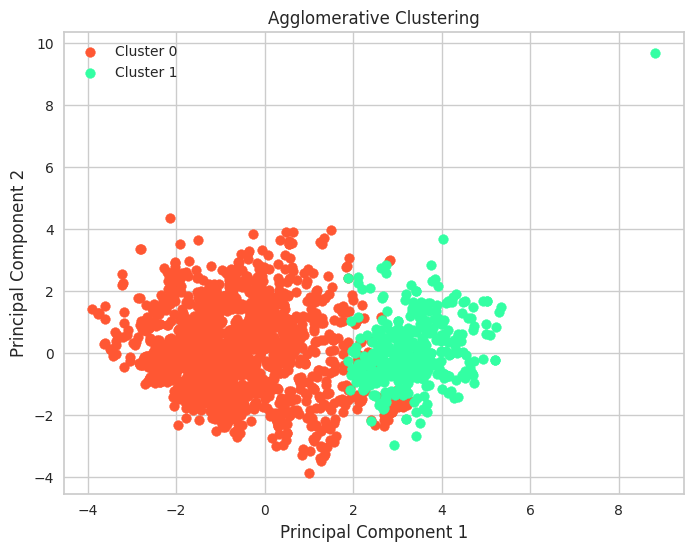

In [75]:
# Fit Agglomerative Clustering model
clustering = AgglomerativeClustering(n_clusters=2)
cluster_labels = clustering.fit_predict(Z_pca)

# Add the cluster labels to the original dataframe
df_clustered = df.copy()
df_clustered['Cluster'] = cluster_labels

# Analyze Clusters
cluster_counts = df_clustered['Cluster'].value_counts()
print('Cluster Counts:')
print(cluster_counts)

# Specify  font 
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

# color palette for the clusters
colors = ['#FF5733', '#33FFA3']

# Creating a scatter plot to visualize the clusters
plt.figure(figsize=(8, 6))
for cluster_label in range(2):
    plt.scatter(Z_pca[cluster_labels == cluster_label, 0], Z_pca[cluster_labels == cluster_label, 1], label=f'Cluster {cluster_label}', c=colors[cluster_label])
plt.title('Agglomerative Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()



### Clustering profiling
This involves the profiling of the segments and to see where the customers belong by studying the patterns of the clusters.

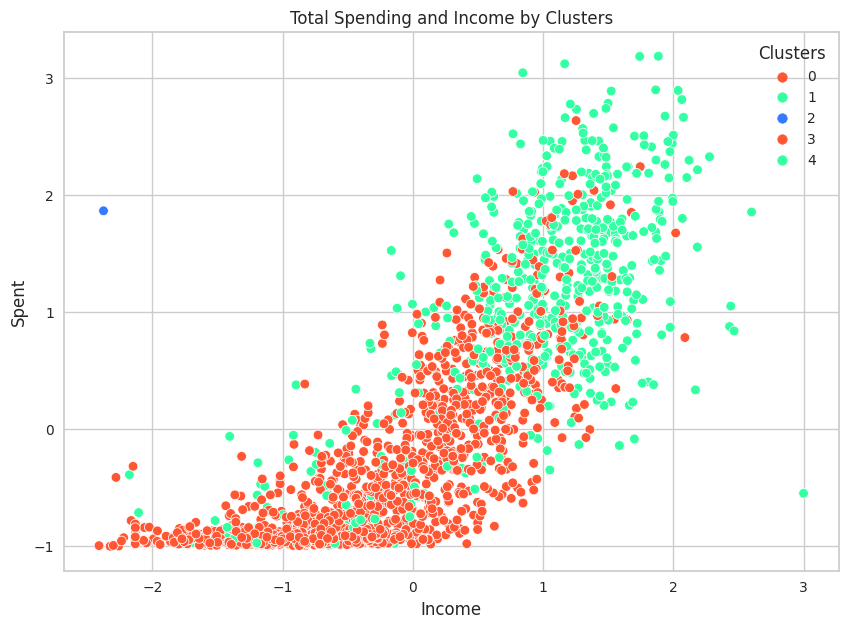

In [74]:
# Adding cluster labels to the original dataset
clusters = cluster_labels
df['Clusters'] = clusters.astype(int)

# Defining a custom color palette
custom_palette = ['#FF5733', '#33FFA3', '#337AFF']

# Specify  font 
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

# Create a scatterplot with the custom color palette
plt.figure(figsize=[10, 7])
sns.scatterplot(data=df, x='Income', y='Spent', hue='Clusters', palette=custom_palette)
plt.title('Total Spending and Income by Clusters')
plt.show()


**Insights**:
* Cluster 0: High Income and High Spending
* Cluster 1: Low Income and Low Spending

## 2.K-Means Clustering

I'll look for the optimal k using the elbow method and sihoutte score 

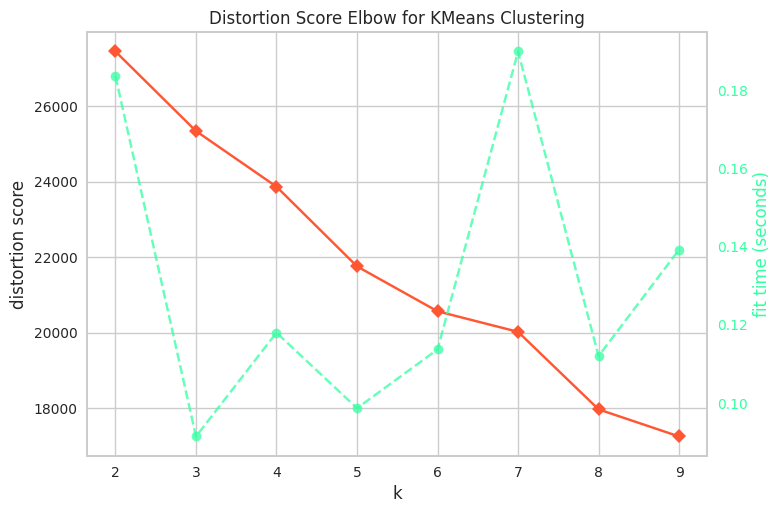

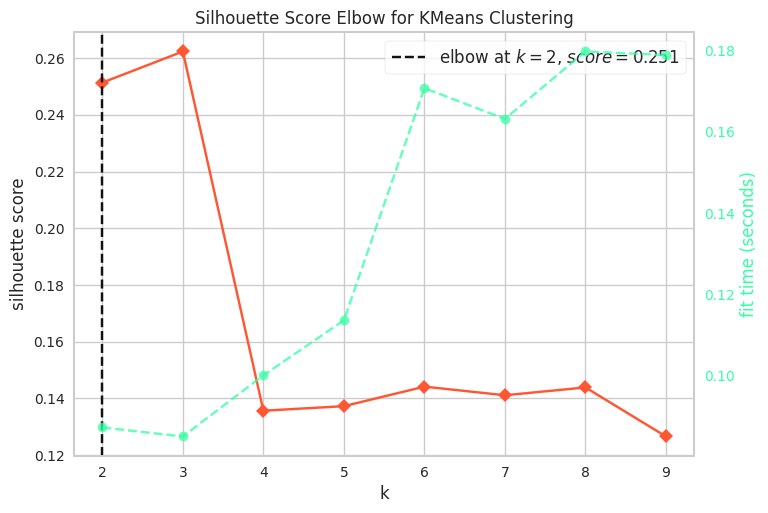

In [73]:
# elbow plot
visualizer = KElbowVisualizer(KMeans(),k=(2,10))
visualizer.fit(df) 
visualizer.poof()
plt.show()

# Specify  font 
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

# silhoutte score plot
visualizer = KElbowVisualizer(KMeans(random_state=23),k=(2,10),metric='silhouette')
visualizer.fit(df) 
visualizer.show()
plt.show()

Now with two different plots we comfirm from that the optimal number of clusters is 2 .Next I'll fit a k-means model with k=2.

In [19]:
# Create a K-Means clustering model with k=2
kmeans = KMeans(n_clusters=2)

# Fitting the model to the transformed data
kmeans.fit(Z_pca)

# Getting cluster assignments for each data point
cluster_labels = kmeans.labels_

# Print the cluster assignments
print("Cluster Labels:", cluster_labels)



Cluster Labels: [1 0 1 ... 1 0 0]


### Cluster Profiling

Cluster Statistics:
           Income  Total_Spending
Cluster                          
0       -0.350832       -0.413337
1        0.911134        1.073463


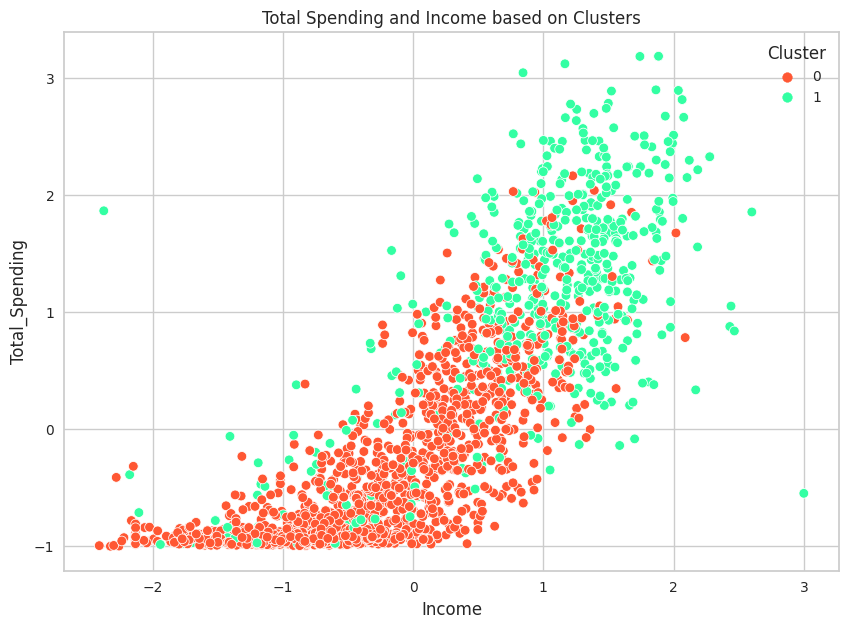

In [24]:
# Create a DataFrame with the original data and cluster assignments
data_with_clusters = pd.DataFrame({'Income': df['Income'], 'Total_Spending': df['Spent'], 'Cluster': cluster_labels})

# Group data by cluster and calculate mean values
cluster_stats = data_with_clusters.groupby('Cluster').mean()

# Print cluster statistics
print("Cluster Statistics:")
print(cluster_stats)

# Visualize the clusters using a scatterplot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
colors = ['#FF5733', '#33FFA3']
palette = sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data=data_with_clusters, x='Income', y='Total_Spending', hue='Cluster', palette=palette)
plt.title('Total Spending and Income based on Clusters')
plt.show()


## 3. DBSCAN

In [32]:

# Assuming all columns in Z_pca are your features
X = Z_pca  

# Define a range of parameter values to search over
param_grid = {
    'eps': np.linspace(0.1, 1.0, 10),
    'min_samples': [3, 5, 7, 10]  
}

# Create a DBSCAN model
dbscan = DBSCAN()

# Perform grid search using silhouette score as the scoring metric
def silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    return silhouette_avg

grid_search = GridSearchCV(dbscan, param_grid, scoring=silhouette_scorer, cv=5)
grid_search.fit(X)

# Get the best parameters from the grid search
best_eps = grid_search.best_params_['eps']
best_min_samples = grid_search.best_params_['min_samples']

# Create the final DBSCAN model with the best parameters
final_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
cluster_labels = final_dbscan.fit_predict(X)


### Cluster profiling

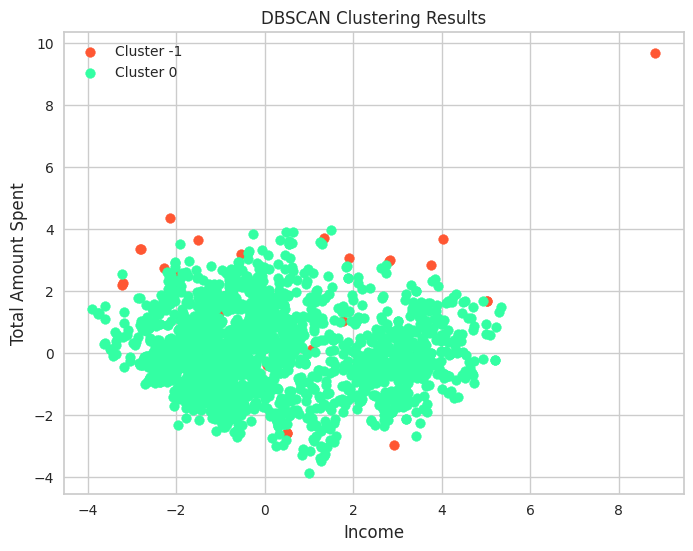

In [38]:
# Create a scatter plot to visualize the clusters
plt.figure(figsize=(8, 6))

# Scatter plot each cluster with a different color
for cluster_label in np.unique(cluster_labels):
    cluster_points = X[cluster_labels == cluster_label]
    plt.scatter(
        cluster_points[:, 0],  # Assuming column 0 is "income"
        cluster_points[:, 1],  # Assuming column 1 is "total amount spent"
        label=f'Cluster {cluster_label}'
    )

plt.title('DBSCAN Clustering Results')
plt.xlabel('Income')
plt.ylabel('Total Amount Spent')
plt.legend()
plt.show()


## 4. Mean Shift

In [50]:
# Assign DataFrame named Z_pca to variable X
X = Z_pca

# Estimate bandwidth using a quantile 
bandwidth = estimate_bandwidth(X, quantile=0.1)

# Create a Mean Shift clustering model with the estimated bandwidth
mean_shift = MeanShift(bandwidth=bandwidth)

# Fit the Mean Shift model to your data
mean_shift.fit(X)

# Get cluster labels for each data point
yhat_ms = mean_shift.predict(X)

# Find unique clusters 
clusters_ms = np.unique(yhat_ms)
print("Clusters of Mean Shift:", clusters_ms)

# Get cluster labels
labels_ms = mean_shift.labels_

# Add cluster labels to DataFrame
df['MS_Cluster'] = labels_ms

# Calculate cluster centroids
centroids_ms = mean_shift.cluster_centers_


Clusters of Mean Shift: [0 1 2 3 4]


### Cluster profilling

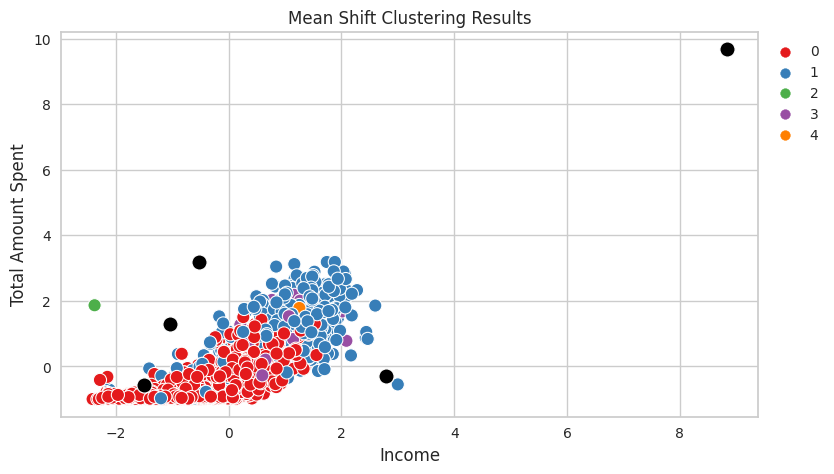

In [72]:
# plot DataFrame named df with 'Income' and 'Spent' columns
plt.figure(figsize=(9, 5))
ax = sns.scatterplot(data=df, x='Income', y='Spent', hue='MS_Cluster', palette='Set1', s=90)
ax = sns.scatterplot(x=centroids_ms[:, 0], y=centroids_ms[:, 1], s=120, color='black')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Mean Shift Clustering Results')
plt.xlabel('Income')
plt.ylabel('Total Amount Spent')
plt.show()


## Model Evaluation Metrics

**CLUSTER EVALUATION**
Cluster evaluation involves the assessment of how effectively a clustering algorithm generates its outcomes. It is important to consider this when comparing two clustering methods or ensuring that any discovered patterns in the data are meaningful.

**SILHOUETTE VALUE**: The Silhouette value measures the proximity of an object within its own cluster compared to other clusters. A high silhouette value indicates that an object is well-matched with its own cluster and poorly-matched with neighboring clusters. Silhouette values range from -1 to +1, with +1 indicating a perfect fit and -1 indicating a poor fit.

**DAVIES-BOULDIN SCORE**: The Davies-Bouldin score quantifies the ratio of inter-cluster distances to intra-cluster distances. It represents the average similarity between each cluster and its most similar cluster. This score is easy to compute and falls within the range of 0 to 1. A lower score indicates better cluster validation.

In [71]:
from sklearn import metrics

# Calculate silhouette scores for different clustering methods
silhouette_scores = [
    metrics.silhouette_score(Z_pca, cluster_labels),
    metrics.silhouette_score(Z_pca, kmeans.labels_),
    metrics.silhouette_score(Z_pca,cluster_labels),  
    metrics.silhouette_score(Z_pca, mean_shift.labels_)
]

# Calculate Davies-Bouldin scores for different clustering methods
davies_bouldin_scores = [
    metrics.davies_bouldin_score(Z_pca, cluster_labels),
    metrics.davies_bouldin_score(Z_pca, kmeans.labels_),
    metrics.davies_bouldin_score(Z_pca,cluster_labels),  
    metrics.davies_bouldin_score(Z_pca, mean_shift.labels_)
]


In [69]:
# Create a DataFrame for evaluation metrics
score_df = pd.DataFrame({
    'Algorithm': ["Agglomerative","K-means","DBSCAN", "Mean-Shift"],
    'Silhouette Score': silhouette_scores,
    'Davies-Bouldin Scores': davies_bouldin_scores
})

print(score_df)

       Algorithm  Silhouette Score  Davies-Bouldin Scores
0  Agglomerative          0.208701               0.947358
1        K-means          0.417146               1.000963
2         DBSCAN          0.208701               0.947358
3     Mean-Shift          0.208701               0.947358


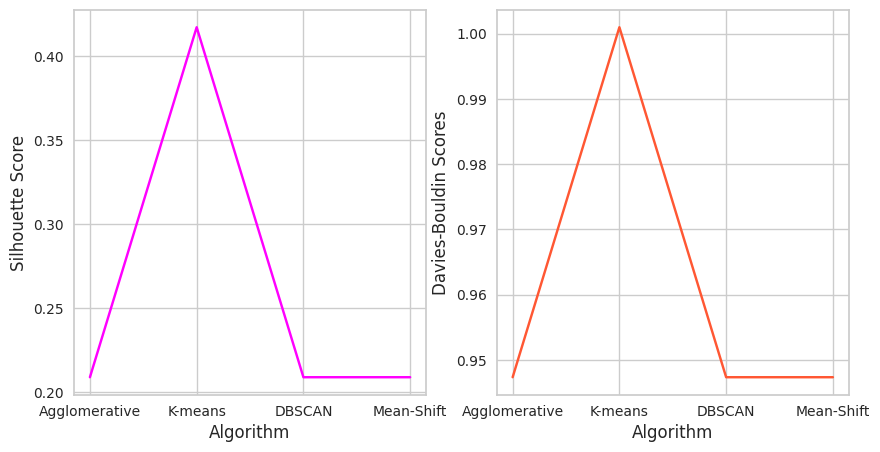

In [70]:
# plotting the result of the DataFrame
fig,axes = plt.subplots(1, 2, figsize=(10,5))
sns.lineplot(data=score_df,x='Algorithm',y='Silhouette Score',color='Magenta',ax=axes[0])
sns.lineplot(data=score_df,x='Algorithm',y='Davies-Bouldin Scores',ax=axes[1])
plt.show()

The clustering results, based on the Silhouette Score and Davies-Bouldin Scores, provide insights into the quality of the customer segmentation achieved by different algorithms:

**K-means**: This algorithm appears to perform the best among the options, as it has the highest Silhouette Score of approximately 0.417 and a Davies-Bouldin Score close to 1. The high Silhouette Score indicates that the clusters are well-separated, with data points closer to their own cluster centers than to neighboring clusters. The Davies-Bouldin Score, which should be as low as possible, suggests that the clusters are distinct from each other.

**Agglomerative (Heirarchical)**: This algorithm has a lower Silhouette Score of around 0.209 compared to K-means, indicating that the clusters may not be as well-defined. However, the Davies-Bouldin Score is still relatively low, suggesting that the clusters are distinguishable from each other.

**DBSCAN**: The Silhouette Score and Davies-Bouldin Score for DBSCAN match those of the Agglomerative algorithm. This suggests that DBSCAN may not be the most suitable algorithm for this dataset, as it performs similarly to Agglomerative but with more complex parameter tuning.

**Mean-Shift**: Mean-Shift also has the same scores as Agglomerative and DBSCAN. This indicates that Mean-Shift, Agglomerative, and DBSCAN produce clusters of similar quality, but K-means outperforms them in terms of Silhouette Score.

In conclusion, based on these results, K-means appears to be the best choice for customer segmentation in this scenario, as it provides the highest Silhouette Score and a low Davies-Bouldin Score, indicating well-defined and separate clusters